### EN2550: Assignment 03 on Object Counting on a Conveyor Belt 
#### Connected Component Analysis 
In this part, we will generate an indexed image representing connected components in `conveyor_f101.png` image. Notice that, as there are three square nuts and one hexagonal nut in the image, there will be five connected components (backgound will be assigned the label 0). 

1. Open the `hexnut_template.png`, `squarenut_template.png` and `conveyor_f100.png` and display. 

In [3]:
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

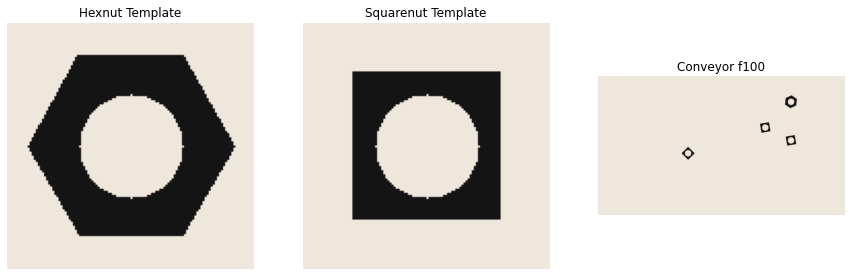

In [8]:
hexnut_template = cv.imread('hexnut_template.png', cv.IMREAD_COLOR)
squarenut_template =  cv.imread('squarenut_template.png', cv.IMREAD_COLOR)
conveyor_f100 =  cv.imread('conveyor_f100.png', cv.IMREAD_COLOR)

fig, ax = plt. subplots(1,3, figsize = (15, 5))
ax[0].imshow(cv.cvtColor(hexnut_template, cv.COLOR_RGB2BGR)); ax[0].axis('off'); ax[0].set_title("Hexnut Template") 
ax[1].imshow(cv.cvtColor(squarenut_template, cv.COLOR_RGB2BGR)); ax[1].axis('off'); ax[1].set_title("Squarenut Template") 
ax[2].imshow(cv.cvtColor(conveyor_f100, cv.COLOR_RGB2BGR)); ax[2].axis('off'); ax[2].set_title("Conveyor f100") 
plt.show() 

2. Convert the images to grayscale and apply **Otsu's thresholding** to obtain the binarized image. Do this for both the templates and belt images. See https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html for a guide. State the threshold value (automatically) selected in the operation. Display the output images. 

    **Problem Discussion** - 
    > Otsu's Thresholding is similar to simple binary thresholding, however, instead of giving the threshold value manually, Otsu's Thresholding calculates a suitable threshold value automatically, such that the two pixel value distributions seperated by the threshold will have the minimum standard variation values. 

In [26]:
def variance(start, end, hist): 
    "calculate the variance of the pixel value distribution from start index to end index" 
    if start == end: return 0 
    count = np.sum(hist[start:end]) 
    mean = np.sum([pixel_val * hist[pixel_val] for pixel_val in range(start, end)]) / count 
    var = np.sum([(pixel_val - mean)**2 * hist[pixel_val] for pixel_val in range(start, end)]) 
    return var 

def OtsuThresholding(img): 
    "perform Otsu's Thresholding on a given image" 
    # step 1 - convert the color img into a grayscale img 
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 

    # step 2 - finding the histogram of the grayscale img 
    hist = cv.calcHist([img], [0], None, [256], [0, 256]) 

    # step 3 - calculating the threshold value 
    min_total_var = np.inf 
    threshold = -1 
    for i in range(1, 256): 
        total_var = variance(0, i, hist) + variance(i, 256, hist) 
        if (total_var < min_total_var): 
            min_total_var = total_var
            threshold = i 
    # step 4 - verifying the threshold value 
    cv_threshold, img_ = cv.threshold(img, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    print("threshold = %d, automatic threshold = %g" %(threshold, cv_threshold)) 

    # step 5 - performing simple thresholding 
    threshold, thresholded_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY) 
    return thresholded_img 

C:\Users\HI\AppData\Local\Temp/ipykernel_4032/3422143680.py:5: RuntimeWarning: invalid value encountered in float_scalars
  mean = np.sum([pixel_val * hist[pixel_val] for pixel_val in range(start, end)]) / count


threshold = 21, automatic threshold = 20
threshold = 21, automatic threshold = 20
threshold = 21, automatic threshold = 20


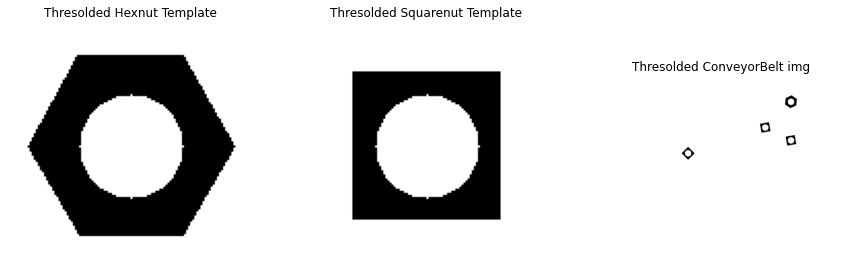

In [28]:
imgs = [OtsuThresholding(hexnut_template), OtsuThresholding(squarenut_template), OtsuThresholding(conveyor_f100)] 
titles = ["Thresolded Hexnut Template", "Thresolded Squarenut Template", "Thresolded ConveyorBelt img"] 

fig, ax = plt.subplots(1, len(imgs), figsize = (15, 5))
for i in range(len(imgs)): 
    ax[i].imshow(imgs[i], cmap='gray'); ax[i].axis('off'); ax[i].set_title(titles[i]) 

3. Carry out **morphological closing** to remove small holes inside the foreground. Use a 3×3 kernel. See https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html for a guide. 

    **Problem Discussion** - 
    > - Notice that, here in this images, ***the foreground is in black and the background is in white***. 
    > - Therefore, to remove the white holes in the black foreground, we have to perform ***morphological opening; firstly erosion then dilation***. 
    > - In morphological opening, the first erosion operation will shrink the white colored regions, thus removing the white spots/holes in the black foreground. Then, the second dilation operation will recover the previously removed white background region. 
    > - In this manner, we can remove the white noises in the black foreground, while keeping the forground and background areas mostly unchanged. 

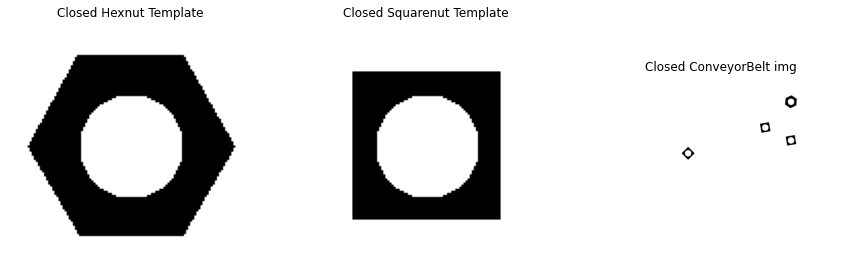

In [38]:
kernel = np.ones((3, 3), dtype=np.uint8) 
closed_imgs = [] 
for img in imgs: 
    closed_img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel) 
    closed_imgs.append(closed_img) 
titles = ["Closed Hexnut Template", "Closed Squarenut Template", "Closed ConveyorBelt img"] 

fig, ax = plt.subplots(1, len(closed_imgs), figsize = (15, 5))
for i in range(len(closed_imgs)): 
    ax[i].imshow(closed_imgs[i], cmap='gray'); ax[i].axis('off'); ax[i].set_title(titles[i]) 

> - Observe that the inner circular edges in the nexnut and squarenut have become smoother due to morphological opening. 